<a href="https://colab.research.google.com/github/ulfiizza27/2141720052-Machine-Learning-2023/blob/main/Week%2010/Praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1**
## RNN untuk Analisis Sentimen

### **Setup**
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Everyone in this movie tells Raffy Carruthers how talented she is, what a great director she\'ll one day turn out to be, etc. I think they\'re just being nice. Even Kimble Rendall, who directed this film, shows more talent than she does. "The next Jane Campion", they call her; and, even apart from the fact that they\'re both over-rated, the two have SO much in common. They both direct movies. They\'re both women. They\'re both Australian. (Well, give or take.)<br /><br />Yep: it\'s one of those films in which a character is deemed to be brilliant, and we just have to swallow hard and accept it. But I\'ll say this for Carruthers: she\'s cute. -And fascinating. No, really. Here are some thoughts on her lack of talent:<br /><br />(1) Part of a director\'s talent lies in dealing with people. Why is Carruthers so phenomenally bad at getting her crew to even take notice of her? So as to make it easier for everyone to wander off the set and get killed, I expect.<br /><br />(2) Why 

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[305,   8,  11, ...,   0,   0,   0],
       [ 10,  63, 405, ...,   0,   0,   0],
       [ 10, 116,  11, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Everyone in this movie tells Raffy Carruthers how talented she is, what a great director she\'ll one day turn out to be, etc. I think they\'re just being nice. Even Kimble Rendall, who directed this film, shows more talent than she does. "The next Jane Campion", they call her; and, even apart from the fact that they\'re both over-rated, the two have SO much in common. They both direct movies. They\'re both women. They\'re both Australian. (Well, give or take.)<br /><br />Yep: it\'s one of those films in which a character is deemed to be brilliant, and we just have to swallow hard and accept it. But I\'ll say this for Carruthers: she\'s cute. -And fascinating. No, really. Here are some thoughts on her lack of talent:<br /><br />(1) Part of a director\'s talent lies in dealing with people. Why is Carruthers so phenomenally bad at getting her crew to even take notice of her? So as to make it easier for everyone to wander off the set and get killed, I expect.<br /><br />(2) Wh

### **Buat Model**

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
 - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
 - Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 10s 10s/step
[0.0132915]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 171ms/step
[0.0132915]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 54s 106ms/step - loss: 0.6344 - accuracy: 0.5838 - val_loss: 0.4760 - val_accuracy: 0.7755
Epoch 2/10
391/391 [==============================] - 25s 65ms/step - loss: 0.4016 - accuracy: 0.8160 - val_loss: 0.3771 - val_accuracy: 0.8135
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3398 - accuracy: 0.8480 - val_loss: 0.3351 - val_accuracy: 0.8453
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3214 - accuracy: 0.8597 - val_loss: 0.3304 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3141 - accuracy: 0.8645 - val_loss: 0.3270 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3052 - accuracy: 0.8692 - val_loss: 0.3218 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3032 - accuracy: 0.8689 - val_loss: 0.3216 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3152 - accuracy: 0.8569
Test Loss: 0.3151855766773224
Test Accuracy: 0.8569200038909912


(0.0, 0.6512164622545242)

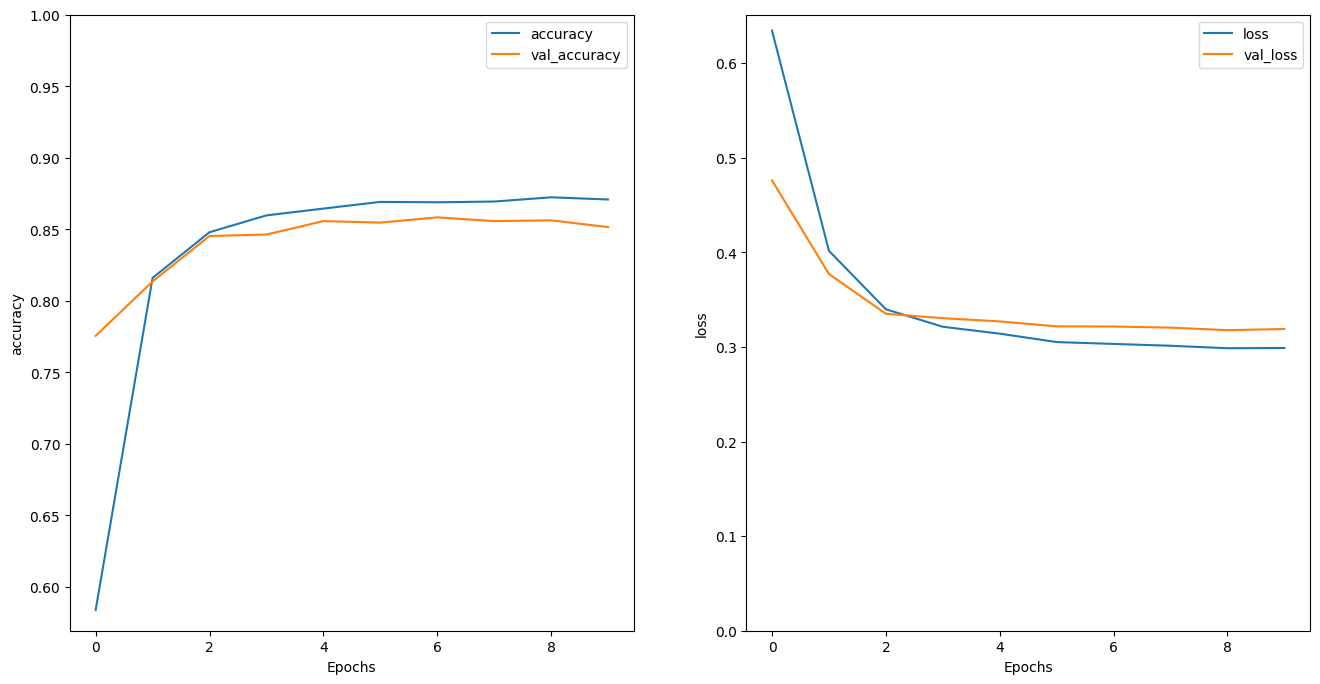

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 84ms/step
[0.89890945]


Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 153ms/step - loss: 0.6260 - accuracy: 0.5908 - val_loss: 0.4422 - val_accuracy: 0.8031
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3893 - accuracy: 0.8312 - val_loss: 0.3466 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3326 - accuracy: 0.8578 - val_loss: 0.3435 - val_accuracy: 0.8661
Epoch 4/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3204 - accuracy: 0.8648 - val_loss: 0.3218 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3155 - accuracy: 0.8662 - val_loss: 0.3218 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3111 - accuracy: 0.8687 - val_loss: 0.3344 - val_accuracy: 0.8391
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3055 - accuracy: 0.8711 - val_loss: 0.3257 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 54ms/step - loss: 0.3259 - accuracy: 0.8416
Test Loss: 0.32588452100753784
Test Accuracy: 0.8416399955749512


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8282667]]


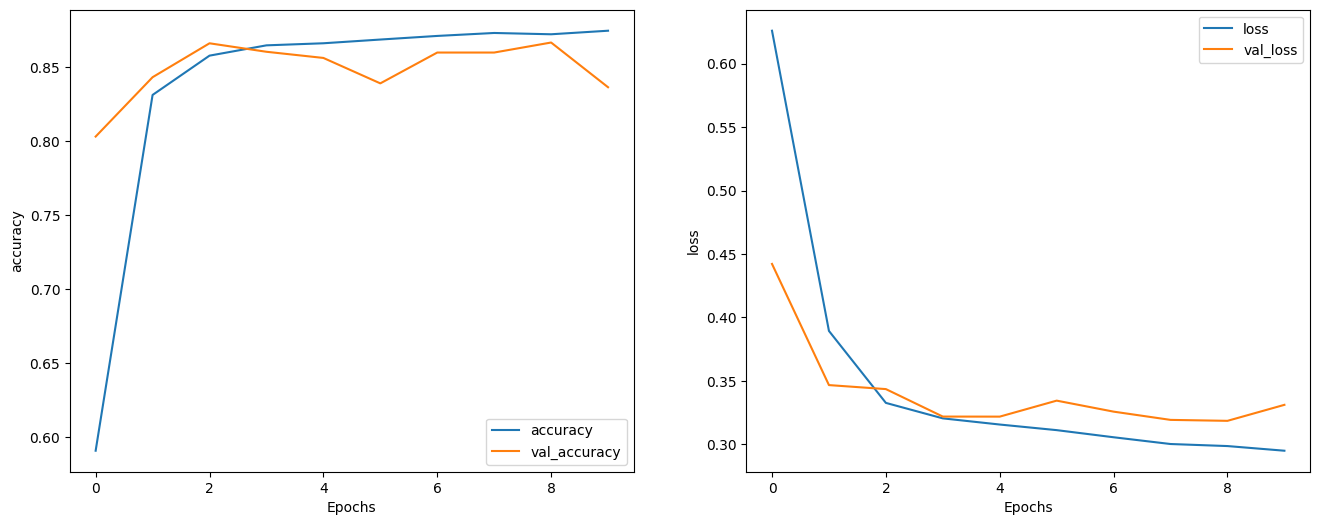

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')